In [1]:
from pyxtal import Group, Wyckoff_position
from pymatgen.core import Structure, Composition
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius

import rich
import pandas as pda
import seaborn as sns
import rho_plus as rp
IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

%load_ext rich

In [2]:
from baysic.utils import load_mp20
from baysic.wyckoff_span import Plane, Line, Point

df = load_mp20('train')

In [74]:
from baysic.pyro_generator import SystemStructureModel
from baysic.config import LogConfig, SearchConfig
from pymatgen.core import Composition
from baysic.lattice import HexagonalLattice, TetragonalLattice, OrthorhombicLattice
import torch
import pyro.distributions as dist

log = LogConfig()
search = SearchConfig()
comp = Composition('Ba2YCu3O7')
lat_model = HexagonalLattice

self = SystemStructureModel(log, search, comp, lat_model, force_group=143)

self.volume = (self.volume_ratio + self.MIN_LATTICE_RATIO) * self.atom_volume
self.lattice = self.lattice_model(self.volume).to_lattice()
group = self.group_options[self.group_opt]
num_atoms = list(self.comp.values())
all_wps = group.Wyckoff_positions
mults = torch.tensor([wp.multiplicity for wp in all_wps]).float()
has_freedom = torch.tensor([wp.get_dof() != 0 for wp in all_wps])
def try_assignment():
    complete_assignment = []
    for count in num_atoms:
        removed = torch.zeros_like(has_freedom)
        assignment = []
        curr_count = count
        while curr_count != 0:
            is_possible = torch.where(~removed & (mults <= curr_count))[0]
            if len(is_possible) == 0:
                return None
            weights = mults[is_possible] * 3
            _uniq, inv, counts = torch.unique(mults[is_possible], return_inverse=True, return_counts=True)
            weights /= counts[inv]
            weights /= weights.sum()
            selection = is_possible[dist.Categorical(probs=weights).sample()].item()
            assignment.append(all_wps[selection].letter)
            curr_count -= mults[selection].item()
            if not has_freedom[selection]:
                removed[selection] = True

        complete_assignment.append(assignment)
    return complete_assignment

combs = []
for _ in range(100):
    comb = try_assignment()
    if comb is not None:
        combs.append(comb)

len(combs)

/tmp/ipykernel_871311/975064847.py:21: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  has_freedom = torch.tensor([wp.get_dof() != 0 for wp in all_wps])


100

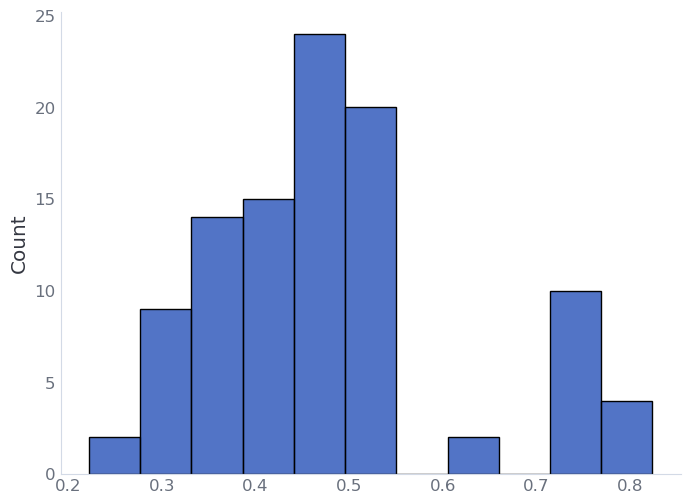

In [75]:
from baysic.wyckoff_span import min_dist_ratio
from pymatgen.core import Lattice
import itertools
from math import e
import numpy as np
from pymatgen.core import SymmOp, Lattice
from pyxtal import Wyckoff_position
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
from baysic.utils import json_to_df
from baysic.wyckoff_span import WyckoffSpan, is_nonzero, Plane, Line, Point

def subset_of(span1, span2):
    if span1.dim > span2.dim:
        return False
    elif span1.dim == span2.dim:
        return span1 == span2
    else:
        test_params = np.random.randn(10, span1.dim)
        test_pts = np.array([
            span1(*params) for params in test_params
        ])

        if all([span2.contains(test_pt) for test_pt in test_pts]):
            return True
        else:
            return False

def min_dist_ratio(sg_num, wps, species, lattice: Lattice) -> float:
    spans = []
    span_elements = []

    for specie, symbol in zip(species, wps):
        wp = Wyckoff_position.from_group_and_letter(sg_num, symbol, style='spglib')
        if wp.get_dof() != 3:
            radius = CovalentRadius.radius[specie.symbol]
            for op in wp.ops:
                n_dof = sum(is_nonzero(op.rotation_matrix, axis=0))
                span = (Point, Line, Plane)[n_dof](op)
                did_add = False
                for span_i, prev_span in enumerate(spans):
                    if span.dim == prev_span.dim and span == prev_span:
                        span_elements[span_i].append(specie)
                        did_add = True
                        break
                if not did_add:
                    spans.append(span)
                    span_elements.append([specie])

    spans = np.array(spans)
    span_elements = np.array(span_elements, dtype=object)
    order = np.argsort([-span.dim for span in spans])
    spans = spans[order]
    span_elements = span_elements[order]

    for i, span in enumerate(spans):
        for j, prev_span in enumerate(spans[:i]):
            if subset_of(span, prev_span):
                print('Found subset')
                span_elements[j].extend(span_elements[i])

    dist_ratios = []
    for span, species in zip(spans, span_elements):
        radii = [CovalentRadius.radius[specie.symbol] for specie in species]
        dist_ratios.append(span.dist_ratio(lattice, radii))

    return np.min(dist_ratios) if dist_ratios else np.inf

from pymatgen.core import SymmOp

import matplotlib.pyplot as plt
dist_ratios = [
    min_dist_ratio(self.group_options[0].number, sum(comb, []), sum([[el] * len(wp) for wp, el in zip(comb, self.comp.elements)], []), self.lattice)
    for comb in combs
]

fig, ax = plt.subplots()
sns.histplot(dist_ratios, ax=ax)
rp.smart_ticks(ax, xaxis=True)

<Axes: xlabel='ratio', ylabel='count'>

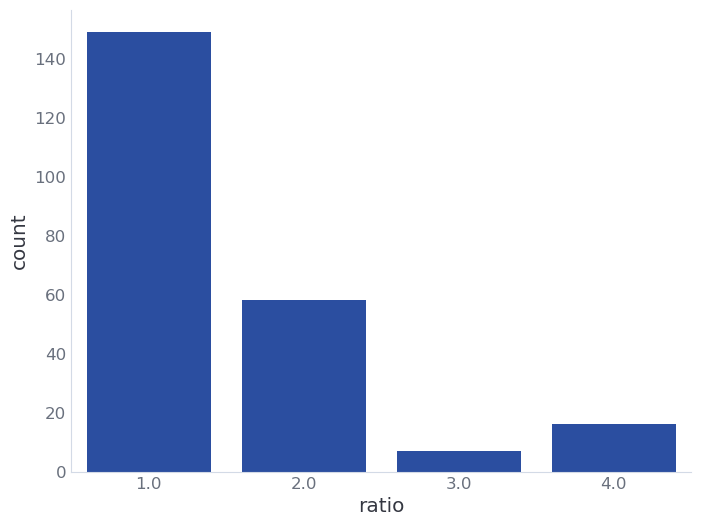

In [48]:
from gemmi import SpaceGroup, UnitCell
from pyxtal import Group, Wyckoff_position
from pymatgen.core import SymmOp
from pyxtal.symmetry import are_equivalent_ops
import pandas as pd
import seaborn as sns

gdf = []
for g in range(1, 231):

    p_to_c = SymmOp.from_xyz_str(SpaceGroup(g).centred_to_primitive().inverse().triplet())

    ops = Group(g).Wyckoff_positions[0].ops
    new_ops = [p_to_c * op for op in ops]
    uniq = []
    for i, op in enumerate(new_ops):
        if all(not are_equivalent_ops(op, prev_op) for prev_op in new_ops[:i]):
            uniq.append(op)

    gdf.append({'uniq': len(uniq), 'total': len(new_ops), 'ratio': len(new_ops) / len(uniq)})

gdf = pd.DataFrame(gdf)
sns.countplot(gdf, x='ratio')

In [45]:
[op.as_xyz_str() for op in uniq]


[
    'x+z, -x+y+z, -y+z',
    '-y+z, x+z, -x+y+z',
    '-x+y+z, -y+z, x+z',
    '-y+z+1/2, -x+y+z+1/2, x+z+1/2',
    '-x+y+z+1/2, x+z+1/2, -y+z+1/2',
    'x+z+1/2, -y+z+1/2, -x+y+z+1/2'
]

In [44]:
[op.as_xyz_str() for op in ops]


[
    'x, y, z',
    '-y, x-y, z',
    '-x+y, -x, z',
    '-y, -x, z+1/2',
    '-x+y, y, z+1/2',
    'x, x-y, z+1/2',
    'x+2/3, y+1/3, z+1/3',
    '-y+2/3, x-y+1/3, z+1/3',
    '-x+y+2/3, -x+1/3, z+1/3',
    '-y+2/3, -x+1/3, z+5/6',
    '-x+y+2/3, y+1/3, z+5/6',
    'x+2/3, x-y+1/3, z+5/6',
    'x+1/3, y+2/3, z+2/3',
    '-y+1/3, x-y+2/3, z+2/3',
    '-x+y+1/3, -x+2/3, z+2/3',
    '-y+1/3, -x+2/3, z+7/6',
    '-x+y+1/3, y+2/3, z+7/6',
    'x+1/3, x-y+2/3, z+7/6'
]

In [39]:
SpaceGroup(g).centred_to_primitive().inverse()

<gemmi.Op("x+z,-x+y+z,-y+z")>

In [21]:
from baysic.lattice import system_groups
from collections import Counter
import pandas as pd

group_df = []
for k, v in system_groups.items():
    for g in v:
        group_df.append({
            'system': k,
            'number': g.number,
            'hall': g.hall_number,
            'symbol': g.symbol,
            'cellsize': g.cellsize(),
        })

group_df = pd.DataFrame(group_df)
group_df

,system,number,hall,symbol,cellsize
0,monoclinic,3,3,P2,1
1,monoclinic,4,6,P21,1
2,monoclinic,5,9,C2,2
3,monoclinic,6,18,Pm,1
4,monoclinic,7,21,Pc,1
...,...,...,...,...,...
224,orthorhombic,70,336,Fddd,4
225,orthorhombic,71,337,Immm,2
226,orthorhombic,72,338,Ibam,2
227,orthorhombic,73,341,Ibca,2


In [22]:
import spglib

spglib.get_spacegroup_type(336)


{
    'number': 70,
    'international_short': 'Fddd',
    'international_full': 'F 2/d 2/d 2/d',
    'international': 'F d d d',
    'schoenflies': 'D2h^24',
    'hall_number': 336,
    'hall_symbol': '-F 2uv 2vw',
    'choice': '2',
    'pointgroup_international': 'mmm',
    'pointgroup_schoenflies': 'D2h',
    'arithmetic_crystal_class_number': 20,
    'arithmetic_crystal_class_symbol': 'mmmF'
}

In [9]:
Group(336, use_hall=True).get_alternatives()


{
    'No.': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
    'Coset Representative': [
        'x,y,z',
        'z,x,y',
        'y,z,x',
        'y,x,z',
        'z,y,x',
        'x,z,y',
        'x+1/2,y,z',
        'z+1/2,x,y',
        'y+1/2,z,x',
        'y+1/2,x,z',
        'z+1/2,y,x',
        'x+1/2,z,y'
    ],
    'Geometrical Interpretation': [
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None,
        None
    ],
    'Transformed WP': [
        'a b c d e f g h',
        'a b c d g e f h',
        'a b c d f g e h',
        'a b c d f e g h',
        'a b c d g f e h',
        'a b c d e g f h',
        'b a d c e f g h',
        'b a d c g e f h',
        'b a d c f g e h',
        'b a d c f e g h',
        'b a d c g f e h',
        'b a d c e g f h'
    ]
}

In [10]:
import numpy as np
from pymatgen.core import Lattice

comp = Composition('Ag4C2O6')

sg = Group(115)

all_assignments = sg.list_wyckoff_combinations(list(comp.get_el_amt_dict().values()))[0]
print(len(all_assignments))
all_assignments[0]

6660


[['1d', '1c', '1b', '1a'], ['2e'], ['2e', '2e', '2e']]

In [24]:
from baysic.lattice import LATTICES, atomic_volume
from baysic.wyckoff_span import is_nonzero
from rich.progress import track

lat_model = None
for lat in LATTICES:
    if sg.number in [g.number for g in lat.get_groups()]:
        lat_model = lat(atomic_volume(comp))

print(lat_model.lattice_type)

dist_df = []
lat_matrices = [lat_model.to_lattice() for _ in range(10)]

for assignment_i, assignment in track(list(enumerate(all_assignments))):
    spans = []
    span_radii = []
    for specie, wyckoffs in zip(comp.elements, assignment):
        for wyckoff in wyckoffs:
            wp = Wyckoff_position.from_group_and_letter(sg.number, wyckoff, style='spglib')
            if wp.get_dof() != 3:
                radius = CovalentRadius.radius[specie.symbol]
                for op in wp.ops:
                    n_dof = sum(is_nonzero(op.rotation_matrix, axis=0))
                    span = (Point, Line, Plane)[n_dof](op)
                    did_add = False
                    for span_i, prev_span in enumerate(spans):
                        if span.dim == prev_span.dim and span == prev_span:
                            span_radii[span_i].append(radius)
                            did_add = True
                            break
                    if not did_add:
                        spans.append(span)
                        span_radii.append([radius])

    for lat_i, lat_matrix in enumerate(lat_matrices):
        dist_ratios = []
        for span, radii in zip(spans, span_radii):
            min_dist_ratios = np.linspace(0, 1, 100)
            prev_min = 0
            for curr_min in min_dist_ratios[1:]:
                if not span.fits(lat_matrix, np.array(radii) * curr_min):
                    dist_ratios.append(prev_min)
                    break
                else:
                    prev_min = curr_min

            if prev_min == 1:
                dist_ratios.append(prev_min)
        dist_ratio = np.min(dist_ratios)
        dist_df.append({
            'lattice': f'l_{lat_i}',
            'assignment': assignment,
            'assignment_i': assignment_i,
            'min_ratio': dist_ratio,
        })

Output()

tetragonal


In [25]:
import pandas as pd
import seaborn as sns
import rho_plus as rp
from baysic.utils import quick_view, json_to_df
IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

dist_df = pd.DataFrame(dist_df)
dist_df['feasible'] = dist_df.eval('min_ratio >= 0.7')
dist_df['easy'] = dist_df.eval('min_ratio == 1')

In [26]:
dist_df.head()

,lattice,assignment,assignment_i,min_ratio,feasible,easy
0,l_0,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.353535,False,False
1,l_1,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.484848,False,False
2,l_2,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.292929,False,False
3,l_3,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.212121,False,False
4,l_4,"[[1d, 1c, 1b, 1a], [2e], [2e, 2e, 2e]]",0,0.515152,False,False


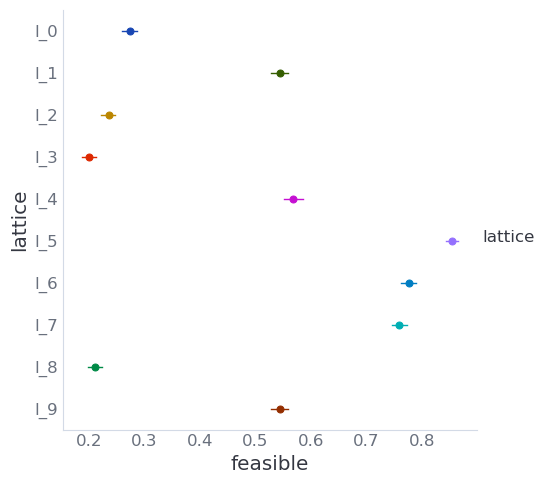

In [35]:
sns.catplot(dist_df, y='lattice', x='feasible', orient='h', kind='point', hue='lattice',
            errorbar=('ci', 99), ms=5, lw=1)

In [43]:
dist_df.groupby('assignment_i').mean(numeric_only=True)['feasible'].sort_values().head(100)


assignment_i
2736    0.0
2761    0.0
5518    0.0
5575    0.0
5619    0.0
       ... 
2580    0.1
2581    0.1
2582    0.1
686     0.1
2583    0.1
Name: feasible, Length: 100, dtype: float64